In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

%matplotlib inline

## Построение распределений и сэмплирование

In [2]:
# параметры распределений
mu0 = [-2, -2]
sigma0 = [[0.55, 0.5], [0.5, 0.55]]
mu1 = [2, 2]
sigma1 = [[0.25, 0.05], [0.05, 0.25]]


In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n,1, 1))
    y1 = torch.ones((n,1, 1))
    sample = torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)
    return sample

In [4]:
d0 = torch.distributions.MultivariateNormal(loc=torch.Tensor([mu0]), covariance_matrix=torch.Tensor([sigma0]))
d1 = torch.distributions.MultivariateNormal(loc=torch.Tensor([mu1]), covariance_matrix=torch.Tensor([sigma1]))

## Обучение классификатора

In [5]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
opt = optim.SGD(lr=1e-2, params=list(layer.parameters()))

[tensor([ 0.2869,  0.3507]), tensor(-0.5849)]


In [6]:
log_freq = 1000
for i in range(100000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000) 
            out = F.sigmoid(layer(x))           
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    x, y = sample(d0, d1, 1024)
    out = F.sigmoid(layer(x))
    opt.zero_grad()
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    opt.step()


Ошибка после 0 итераций: 0.285146
Ошибка после 1 итераций: 0.022907
Ошибка после 2 итераций: 0.014092
Ошибка после 3 итераций: 0.010873
Ошибка после 4 итераций: 0.009385
Ошибка после 5 итераций: 0.008150
Ошибка после 6 итераций: 0.007124
Ошибка после 7 итераций: 0.006643
Ошибка после 8 итераций: 0.006127
Ошибка после 9 итераций: 0.005733
Ошибка после 10 итераций: 0.005346
Ошибка после 11 итераций: 0.005388
Ошибка после 12 итераций: 0.005026
Ошибка после 13 итераций: 0.004837
Ошибка после 14 итераций: 0.004684
Ошибка после 15 итераций: 0.004473
Ошибка после 16 итераций: 0.004197
Ошибка после 17 итераций: 0.004310
Ошибка после 18 итераций: 0.004045
Ошибка после 19 итераций: 0.004013
Ошибка после 20 итераций: 0.003984
Ошибка после 21 итераций: 0.003777
Ошибка после 22 итераций: 0.003661
Ошибка после 23 итераций: 0.003502
Ошибка после 24 итераций: 0.003572
Ошибка после 25 итераций: 0.003493
Ошибка после 26 итераций: 0.003289
Ошибка после 27 итераций: 0.003359
Ошибка после 28 итераций: 0.00

## Визуализация

In [7]:
def get_positions(space):
    x = np.linspace(*space)
    y = np.linspace(*space)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    return X, Y, pos

def plot_values(space, mu, sigma):
    X, Y, pos = get_positions(space)
    rv = multivariate_normal(np.array(mu), np.array(sigma))
    Z = rv.pdf(pos)    
    return X, Y, Z

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


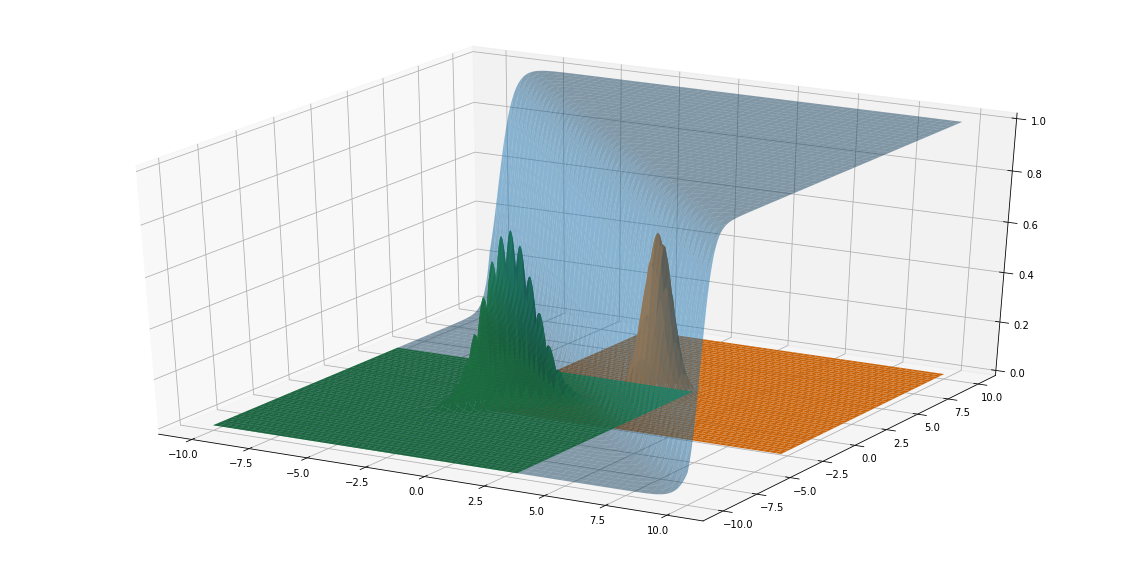

In [8]:
# Чтобы поверхности не сильно перекрывали друг друга на графике - 
# мы берем частично пересекающиеся области значений X и Y
X0, Y0, Z0 = plot_values((-10, 3, 1000), mu0, sigma0)
X1, Y1, Z1 = plot_values((-3, 10, 1000), mu1, sigma1)

X_hat, Y_hat, pos = get_positions((-10, 10, 1000))
with torch.no_grad():
    sm = torch.Tensor(pos)
    Z_hat = F.sigmoid(layer(sm)).numpy()
    Z_hat = Z_hat.reshape(1000,1000)
    
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_hat, Y_hat, Z_hat, alpha=0.5)
ax.plot_surface(X1, Y1, Z1, alpha=1)
ax.plot_surface(X0, Y0, Z0, alpha=1)
fig.show()